<a href="https://colab.research.google.com/github/mostafa-elsharnoby/Image-Processing-Project/blob/draw_lane/draw_lane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
img_paths = '/test_images'
lane_img_path = 'D:/Image Project/Image-Processing-Project/test_images/'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import re
import math

%matplotlib inline

# region of interest

In [3]:
IMG_SHAPE = (720, 1280)

In [4]:
def plot_images(original, modified, title):
    f, (im1, im2) = plt.subplots(1, 2, figsize = (24, 9))
    f.tight_layout()
    im1.imshow(original)
    im1.set_title('Original Image', fontsize = 50)
    im2.imshow(modified, cmap = 'gray')
    im2.set_title(title, fontsize = 50)
    plt.subplots_adjust(left = 0, right = 1, top = 0.9, bottom = 0.)

In [5]:
def get_roi(img, vertices):
    '''
    Transforms an image by preserving only the ROI represented by the
    the 'vertices' and removes the remainder of the image by setting the pixel intensity to 0
    :param img (ndarray): Image
    :param vertices (ndarray): Region of Interest of the image
    :return : Modified image
    '''
    
    vertices = np.array(vertices, ndmin=3, dtype=np.int32)
    if len(img.shape) == 3:
        fill_color = (255,) * 3
    else:
        fill_color = 255
            
    mask = np.zeros_like(img)
    mask = cv2.fillPoly(mask, vertices, fill_color)
    return cv2.bitwise_and(img, mask)

In [6]:
def warp_image(img, warp_shape, src, dst):
    '''
    Performs perspective transformation (PT)
    :param img (ndarray): Image
    :param warp_shape: Shape of the warped image
    :param src (ndarray): Source points
    :param dst (ndarray): Destination points
    :return : Tuple (Transformed image, PT matrix, PT inverse matrix)
    '''
    
    # Get the perspective transformation matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image
    warped = cv2.warpPerspective(img, M, warp_shape, flags=cv2.INTER_LINEAR)
    return warped, M, invM

In [7]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    #hist = cv2.calcHist([img],[0],None,[256],[0,256])
    return hist

In [8]:
def preprocess_image(img, visualise=False):
    '''
    Pre-processes an image. Steps include:
    1. Distortion correction
    2. Perspective Transformation
    3. ROI crop
    
    :param img (ndarray): Original Image
    :param visualise (boolean): Boolean flag for visualisation
    :return : Pre-processed image, (PT matrix, PT inverse matrix)
    '''
    
    ysize = img.shape[0]
    xsize = img.shape[1]
    

    
    # 2. Perspective transformation
    src = np.float32([
        (696,455),    
        (587,455), 
        (235,700),  
        (1075,700)
    ])

    dst = np.float32([
        (xsize - 350, 0),
        (350, 0),
        (350, ysize),
        (xsize - 350, ysize)
    ])

    warped, M, invM = warp_image(img, (xsize, ysize), src, dst)
    plt.plot(get_hist(warped))
    # 3. ROI crop
    vertices = np.array([
        [200, ysize],
        [200, 0],
        [1100, 0],
        [1100, ysize]
    ])

    roi = get_roi(warped, vertices)

    # 4. Visualise the transformation
    if visualise:
        img_copy = np.copy(img)
        roi_copy = np.copy(roi)
        
        cv2.polylines(img_copy, [np.int32(src)], True, (255, 0, 0), 3)
        cv2.polylines(roi_copy, [np.int32(dst)], True, (255, 0, 0), 3)
        
        plot_images(img_copy, roi_copy, 'Bird\'s Eye View Perspective')
      

    return roi, (M, invM)

In [9]:
def get_image(img_path, visualise=False):
    '''
    Load an image from the 'img_path' and pre-process it
    :param img_path (string): Image path
    :param visualise (boolean): Boolean flag for visualisation
    :return : Transformed Image, (PT matrix, PT inv matrix)
    '''
    img = mpimg.imread(img_path)
    return preprocess_image(img, visualise=visualise)

In [10]:
def plot_images(data, layout='row', cols=2, figsize=(20, 12)):
    '''
    Utility function for plotting images
    :param data [(ndarray, string)]: List of data to display, [(image, title)]
    :param layout (string): Layout, row-wise or column-wise
    :param cols (number): Number of columns per row
    :param figsize (number, number): Tuple indicating figure size
    '''
    rows = math.ceil(len(data) / cols)
    f, ax = plt.subplots(figsize=figsize)
    if layout == 'row':
        for idx, d in enumerate(data):
            img, title = d

            plt.subplot(rows, cols, idx+1)
            plt.title(title, fontsize=20)
            plt.axis('off')
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
                
            elif len(img.shape) == 3:
                plt.imshow(img)
                
    elif layout == 'col':
        counter = 0
        for r in range(rows):
            for c in range(cols):
                img, title = data[r + rows*c]
                nb_channels = len(img.shape)
                
                plt.subplot(rows, cols, counter+1)
                plt.title(title, fontsize=20)
                plt.axis('off')
                if len(img.shape) == 2:
                    plt.imshow(img, cmap='gray')
                
                elif len(img.shape) == 3:
                    plt.imshow(img)
              
                counter += 1

    return ax

In [11]:
def binary_threshold(img, low, high):    
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)
        
    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])
            
    output[mask] = 1
    return output

In [12]:
def get_binary_image(img, visualise=False):
    """
    Generate a thresholded binary image using transforms from an ensemble of color spaces: 
    LAB (Yellow), HSV (Yellow + White), HLS (Yellow + White), RGB (White) and 
    Adaptive Thresholding ()
    :param img (ndarray): Warped image
    :param visualise (boolean): Boolean flag for visualisation
    :return (ndarray): Thresholded binary image
    """
    
    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow
      
    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)
    
    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))
   
    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)    

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)
 
    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)
    
    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)
        
    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)
    
    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)
    
    ### Adaptive thresholding: Gaussian kernel 
    # YELLOW
    
    adapt_yellow_S = cv2.adaptiveThreshold(hls[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B
    
    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_L
    
                                                  
    adapt_binary =  adapt_yellow | adapt_white

    ### Ensemble Voting
    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)

    combined[combined < 3] = 0
    combined[combined >= 3] = 1

    if visualise:
        plot_images([
            (img, 'Original'),
            (R_binary, 'R'),
            (hls_binary, 'HLS'),
            (hsv_binary, 'HSV'),
            (lab_binary, 'LAB'),
            (adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_white, 'lab white'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(32, 42))

    return  combined

In [13]:
def get_poly_points(left_fit, right_fit):
    '''
    Get the points for the left lane/ right lane defined by the polynomial coeff's 'left_fit'
    and 'right_fit'
    :param left_fit (ndarray): Coefficients for the polynomial that defines the left lane line
    :param right_fit (ndarray): Coefficients for the polynomial that defines the right lane line
    : return (Tuple(ndarray, ndarray, ndarray, ndarray)): x-y coordinates for the left and right lane lines
    '''
    ysize, xsize = IMG_SHAPE
    
    # Get the points for the entire height of the image
    plot_y = np.linspace(0, ysize-1, ysize)
    plot_xleft = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
    plot_xright = right_fit[0] * plot_y**2 + right_fit[1] * plot_y + right_fit[2]
    
    # But keep only those points that lie within the image
    plot_xleft = plot_xleft[(plot_xleft >= 0) & (plot_xleft <= xsize - 1)]
    plot_xright = plot_xright[(plot_xright >= 0) & (plot_xright <= xsize - 1)]
    plot_yleft = np.linspace(ysize - len(plot_xleft), ysize - 1, len(plot_xleft))
    plot_yright = np.linspace(ysize - len(plot_xright), ysize - 1, len(plot_xright))
    
    return plot_xleft.astype(np.int), plot_yleft.astype(np.int), plot_xright.astype(np.int), plot_yright.astype(np.int)


In [14]:
def check_validity(left_fit, right_fit, diagnostics=False):
    '''
    Determine the validity of lane lines represented by a set of second order polynomial coefficients 
    :param left_fit (ndarray): Coefficients for the 2nd order polynomial that defines the left lane line
    :param right_fit (ndarray): Coefficients for the 2nd order polynomial that defines the right lane line
    :param diagnostics (boolean): Boolean flag for logging
    : return (boolean)
    '''
    
#     if left_fit is None or right_fit is None:
#         return False
    
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Check whether the two lines lie within a plausible distance from one another for three distinct y-values

    y1 = IMG_SHAPE[0] - 1 # Bottom
    y2 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * 0.35) # For the 2nd and 3rd, take values between y1 and the top-most available value.
    y3 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * 0.75)

    # Compute the respective x-values for both lines
    x1l = left_fit[0]  * (y1**2) + left_fit[1]  * y1 + left_fit[2]
    x2l = left_fit[0]  * (y2**2) + left_fit[1]  * y2 + left_fit[2]
    x3l = left_fit[0]  * (y3**2) + left_fit[1]  * y3 + left_fit[2]

    x1r = right_fit[0] * (y1**2) + right_fit[1] * y1 + right_fit[2]
    x2r = right_fit[0] * (y2**2) + right_fit[1] * y2 + right_fit[2]
    x3r = right_fit[0] * (y3**2) + right_fit[1] * y3 + right_fit[2]

    # Compute the L1 norms
    x1_diff = abs(x1l - x1r)
    x2_diff = abs(x2l - x2r)
    x3_diff = abs(x3l - x3r)

    # Define the threshold values for each of the three points
    min_dist_y1 = 480 # 510 # 530 
    max_dist_y1 = 730 # 750 # 660
    min_dist_y2 = 280
    max_dist_y2 = 730 # 660
    min_dist_y3 = 140
    max_dist_y3 = 730 # 660
    
#     if (x1_diff < min_dist_y1) | (x1_diff > max_dist_y1) | \
#         (x2_diff < min_dist_y2) | (x2_diff > max_dist_y2) | \
#         (x3_diff < min_dist_y3) | (x3_diff > max_dist_y3):
#         if diagnostics:
#             print("Violated distance criterion: " +
#                   "x1_diff == {:.2f}, x2_diff == {:.2f}, x3_diff == {:.2f}".format(x1_diff, x2_diff, x3_diff))
#         return False

    # Check whether the line slopes are similar for two distinct y-values
    # x = Ay**2 + By + C
    # dx/dy = 2Ay + B
    
    y1left_dx  = 2 * left_fit[0]  * y1 + left_fit[1]
    y3left_dx  = 2 * left_fit[0]  * y3 + left_fit[1]
    y1right_dx = 2 * right_fit[0] * y1 + right_fit[1]
    y3right_dx = 2 * right_fit[0] * y3 + right_fit[1]

    # Compute the L1-norm
    norm1 = abs(y1left_dx - y1right_dx)
    norm2 = abs(y3left_dx - y3right_dx)
    
#     if diagnostics: print( norm1, norm2)

    # Define the L1 norm threshold
    thresh = 0.6 #0.58 
#     if (norm1 >= thresh) | (norm2 >= thresh):
#         if diagnostics:
#             print("Violated tangent criterion: " +
#                   "norm1 == {:.3f}, norm2 == {:.3f} (thresh == {}).".format(norm1, norm2, thresh))
#             return False
    
    return True

In [15]:
def polyfit_sliding_window(binary, lane_width_px=578, visualise=False, diagnostics=False):
    '''
    Detect lane lines in a thresholded binary image using the sliding window technique
    :param binary (ndarray): Thresholded binary image
    :param lane_width_px (int): Average lane line width (in px) for the warped image 
    computed empirically
    :param visualise (boolean): Boolean flag for visualisation
    :param diagnositics (boolean): Boolean flag for logging
    '''
    
    global cache
    ret = True

    # Sanity check
#     if binary.max() <= 0:
#         return False, np.array([]), np.array([]), np.array([])
    
    # Step 1: Compute the histogram along all the columns in the lower half of the image. 
    # The two most prominent peaks in this histogram will be good indicators of the
    # x-position of the base of the lane lines
    histogram = None
    cutoffs = [int(binary.shape[0] / 2), 0]
    
    for cutoff in cutoffs:
        histogram = np.sum(binary[cutoff:, :], axis=0)
        
        if histogram.max() > 0:
            break

#     if histogram.max() == 0:
#         print('Unable to detect lane lines in this frame. Trying another frame!')
#         return False, np.array([]), np.array([])
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if visualise:
        plot_images([(binary, 'Binary')])
        plt.plot(histogram, 'm', linewidth=4.0)
        plt.plot((midpoint, midpoint), (0, IMG_SHAPE[0]), 'c')
        plt.plot((0, IMG_SHAPE[1]), (cutoff, cutoff), 'c')

    out = np.dstack((binary, binary, binary)) * 255

    nb_windows = 12 # number of sliding windows
    margin = 100 # width of the windows +/- margin
    minpix = 50 # min number of pixels needed to recenter the window
    window_height = int(IMG_SHAPE[0] / nb_windows)
    min_lane_pts = 10  # min number of 'hot' pixels needed to fit a 2nd order polynomial as a 
                    # lane line
    
    # Identify the x-y positions of all nonzero pixels in the image
    # Note: the indices here are equivalent to the coordinate locations of the
    # pixel
    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nb_windows):
        # Identify window boundaries in x and y (and left and right)
        win_y_low = IMG_SHAPE[0] - (1 + window) * window_height
        win_y_high = IMG_SHAPE[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw windows for visualisation
        cv2.rectangle(out, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),\
                      (0, 255, 0), 2)
        cv2.rectangle(out, (win_xright_low, win_y_low), (win_xright_high, win_y_high),\
                      (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) >  minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract pixel positions for the left and right lane lines
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = None, None
    
    # Sanity check; Fit a 2nd order polynomial for each lane line pixels
    if len(leftx) >= min_lane_pts and len(rightx) >= min_lane_pts:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Validate detected lane lines
    #valid = check_validity(left_fit, right_fit, diagnostics=diagnostics)
    valid=True
    #     if not valid:
        # If the detected lane lines are NOT valid:
        # 1. Compute the lane lines as an average of the previously detected lines
        # from the cache and flag this detection cycle as a failure by setting ret=False
        # 2. Else, if cache is empty, return 
        
#         if len(cache) == 0:
#             if diagnostics: print('WARNING: Unable to detect lane lines in this frame.')
#             return False, np.array([]), np.array([])
        
#         avg_params = np.mean(cache, axis=0)
#         left_fit, right_fit = avg_params[0], avg_params[1]
#         ret = False
        
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Color the detected pixels for each lane line
    out[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 10, 255]
    
    
    left_poly_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    right_poly_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])

    # Plot the fitted polynomial
    cv2.polylines(out, np.int32([left_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)
    cv2.polylines(out, np.int32([right_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)

#     if visualise:
#         plot_images([(img, 'Original'), (out, 'Out')], figsize=(30, 40))
        
    return ret, out, np.array([left_fit, right_fit])

In [16]:
def measure_curvature_real(left_fit_cr, right_fit_cr, img_shape):
    '''
    Calculates the curvature of polynomial functions in meters.
    and returns the position of vehical relative to the center of the lane
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = img_shape[0]
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # It was meentioned in one the course note that camera was mounted in the middle of the car,
    # so the postiion of the car is middle of the image, the we calculate the middle of lane using
    # two fitted polynomials
    car_pos = img_shape[1]/2
    left_lane_bottom_x = left_fit_cr[0]*img_shape[0]**2 + left_fit_cr[1]*img_shape[0] + left_fit_cr[2]
    right_lane_bottom_x = right_fit_cr[0]*img_shape[0]**2 + right_fit_cr[1]*img_shape[0] + right_fit_cr[2]
    lane_center_position = ((right_lane_bottom_x - left_lane_bottom_x) / 2) + left_lane_bottom_x
    car_center_offset = (car_pos - lane_center_position) * xm_per_pix
    
    return (left_curverad, right_curverad, car_center_offset)

In [17]:
def draw_colored_lane(img, xleft_points, xright_points, invM):
    ysize = img.shape[0]
    xsize = img.shape[1]
    y = np.linspace(0, ysize-1, ysize)
    
    while(len(y)>len(xleft_points)):
        y = np.delete(y,-1)
    while(len(y)<len(xleft_points)):
        xleft_points = np.delete(xleft_points,-1)
        
    
    left_line_points = np.array([np.transpose(np.vstack([xleft_points, y]))])
    
    while(len(y)>len(xright_points)):
        y = np.delete(y,-1)
    while(len(y)<len(xright_points)):
        xright_points = np.delete(xright_points,-1)
    
    right_line_points = np.array([np.flipud(np.transpose(np.vstack([xright_points, y])))])
    points = np.hstack((left_line_points, right_line_points)).astype(np.int)
    
    colored_lane_img = np.zeros_like(img)
    cv2.fillPoly(colored_lane_img, (points), (0,255,0))
    #inv_perspective = warp_image(colored_lane_img, (xsize,ysize), )
    inv_perspective = cv2.warpPerspective(colored_lane_img, invM, (xsize,ysize), flags=cv2.INTER_LINEAR)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective

In [18]:
def calc_curvature(img, xleft_points, xright_points):
  ysize = img.shape[0]
  y_meter_to_pixel = 30.5/720 #0.0291
  x_meter_to_pixel = 3.7/720 #0.0065
  y = np.linspace(0, ysize-1, ysize)
  
  #convert points from pixel to meter
  xleft_meter = xleft_points * x_meter_to_pixel
  xright_meter = xright_points * x_meter_to_pixel
  y_meter = y * y_meter_to_pixel

  y_eval = np.max(y_meter) #current position of camera

  #Find polynomials of the converted points in meters
  left_fit_meters = np.polyfit(y_meter, xleft_meter, 2)
  right_fit_meters = np.polyfit(y_meter, xright_meter, 2)

  #calculate radius of curvature at point y_eval
  left_curvature = ((1+(2*left_fit_meters[0]*y_eval+left_fit_meters[1])**2)**1.5)/np.absolute(2*left_fit_meters[0])
  right_curvature = ((1+(2*right_fit_meters[0]*y_eval+right_fit_meters[1])**2)**1.5)/np.absolute(2*right_fit_meters[0])

  lane_curvature = np.average([left_curvature, right_curvature])
  return lane_curvature, left_curvature, right_curvature

# **Video Processing**

In [19]:
def video_pipeline(img):
    global running_avg
    global index
    preprocessed_img, perspective_matrices = preprocess_image(img)
    binary_img = get_binary_image(preprocessed_img, visualise=False)
    ret, out, fit = polyfit_sliding_window(binary_img, visualise=False)
    invM = perspective_matrices[1]

    #calculate x points of left line & right line
    xleft_points, _, xright_points, _ = get_poly_points(fit[0], fit[1])
    colored_img = draw_colored_lane(img, xleft_points, xright_points, invM)

#     #calculate radius of curvature using x points
#     lane_curvature, left_rad, right_rad = calc_curvature(binary_img, xleft_points, xright_points)
    
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     fontColor = (0, 0, 0)
#     fontSize=0.5
#     offset = 0 
# #     cv2.putText(img, 'Lane Curvature: {:.0f} m'.format(lane_curvature), (570, 620), font, fontSize, fontColor, 2)
    
    ##sharnoyy's part##
    
    measures = measure_curvature_real(fit[0],fit[1],IMG_SHAPE)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize = 1
    cv2.putText(colored_img, 'Lane Curvature: {:.0f} m'.format(np.mean([measures[0],measures[1]])), 
                (500, 620), font, fontSize, fontColor, 2)
    if(measures[2]<0):
        cv2.putText(colored_img, 'Vehicle offset: {:.4f} m to the left'.format(-1*measures[2]), (500, 650), font, fontSize, fontColor, 2)
    else:
        cv2.putText(colored_img, 'Vehicle offset: {:.4f} m to the right'.format(measures[2]), (500, 650), font, fontSize, fontColor, 2)
    
    
    
    #print(measures)
    ##sharnoyy's part##
    
    
    return colored_img

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



t:  28%|██▊       | 134/485 [00:42<01:53,  3.10it/s, now=None]

TypeError: 'NoneType' object is not subscriptable

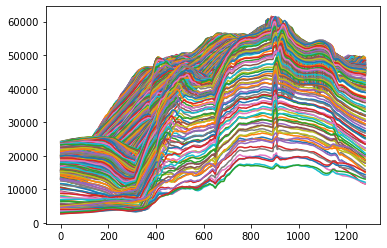

In [20]:
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip

myclip = VideoFileClip('challenge_video.mp4')#.subclip(40,43)
output_vid = 'output.mp4'
clip = myclip.fl_image(video_pipeline)
clip.write_videofile(output_vid, audio=False)
myclip.reader.close()
myclip.close()